In [1]:
library(variableStars)
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(plotly)
library(keras)
library(plotly)
library(abind)
library(fields)


Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-0 (2018-06-19) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


### Read processed files and create big matrix with all rows

In [2]:
setwd("~/Downloads/data/")
system("find . -type f -name \"*.log\" -print0 | xargs -0 cat > ALL.data")
df_all <- data.frame(fread("ALL.data", sep=",", header = F), stringsAsFactors=F)
dim(df_all)
df_all <- df_all[complete.cases(df_all),]
dim(df_all)

[1] 506823   1220

[1] 506557   1220

### Experiment parameters

In [3]:
# Resolution for target frequency [0-100]
input_resolution <- 0.25
output_resolution <- 1.0

# Input dimension
cuts_breaks <- c(-Inf, seq(0, 101, input_resolution), Inf)
input_dim <- length(cuts_breaks) - 1

# Output dimension
num_classes <-
  length(seq(
    from = 0.1,
    to = 14 / 0.0864,
    by = output_resolution
  )) # Buckets of possible classes

### Matrix creation from data

In [4]:
rows <- dim(df_all)[1]
cols <- (dim(df_all)[2] - 2) / 3
dimensions <- 3 # Number of channels
X <- array(0, c(rows, cols, dimensions))
# Y train is a 1D matrix with rows and targets
Y <- matrix(0, nrow = rows, ncol = num_classes)


ind_data <- seq(from=1,to=rows)

# Reshaoe dataframe to matrix slices
X[ind_data, , 1] <- as.matrix(df_all[ind_data, 1:406])
X[ind_data, , 2] <- as.matrix(df_all[ind_data, 406:((406 * 2) - 1)])
X[ind_data, , 3] <- as.matrix(df_all[ind_data, (406 * 2):((406 * 3) - 1)])
Y <- to_categorical(df_all[ind_data, 1220:1220] / 0.0864, num_classes)

dim(X)
dim(Y)

[1] 506557    406      3

[1] 506557    162

### Check that target is not in the trainind data

In [5]:
print(paste0("Check for target 1:"))
flags <- c()
for (i in seq(from=1,to=rows)){
    flags <- c(flags, df_all[i, 1220:1220] %in% rbind(X[i,,1],X[i,,2],X[i,,3]))
}
print(table(flags))

flags <- c()
print(paste0("Check for target 2:"))
for (i in seq(from=1,to=rows)){
    flags <- c(flags, df_all[i, 1219:1219] %in% rbind(X[i,,1],X[i,,2],X[i,,3]))
}
print(table(flags))

[1] "Check for target 1:"
flags
 FALSE 
506557 
[1] "Check for target 2:"
flags
 FALSE   TRUE 
504306   2251 


In [6]:
ind_remove_no_target <- which(apply(Y,1,sum)==1)
paste0("Removing ",length(ind_remove_no_target[ind_remove_no_target==TRUE])," rows with NO target")

X <- X[ind_remove_no_target,,]
Y <- Y[ind_remove_no_target,]

dim(X)
dim(Y)

[1] "Removing 1 rows with NO target"

[1] 506557    406      3

[1] 506557    162

In [7]:
stopifnot(which(is.na(Y))==FALSE)
stopifnot(which(is.na(X))==FALSE)

In [8]:
# Split train/test
smp_size <- floor(0.75 * nrow(X))
set.seed(123)
ind <- sample(seq_len(nrow(X)), size = smp_size)

# Prepare partition
x_train <- X[ind, , ]
x_test  <- X[-ind, , ]
y_train <- Y[ind, ]
y_test  <- Y[-ind, ]
# Check dims
dim(x_train)
dim(y_train)
dim(x_test)
dim(y_test)

[1] 379917    406      3

[1] 379917    162

[1] 126640    406      3

[1] 126640    162

### EDA of data

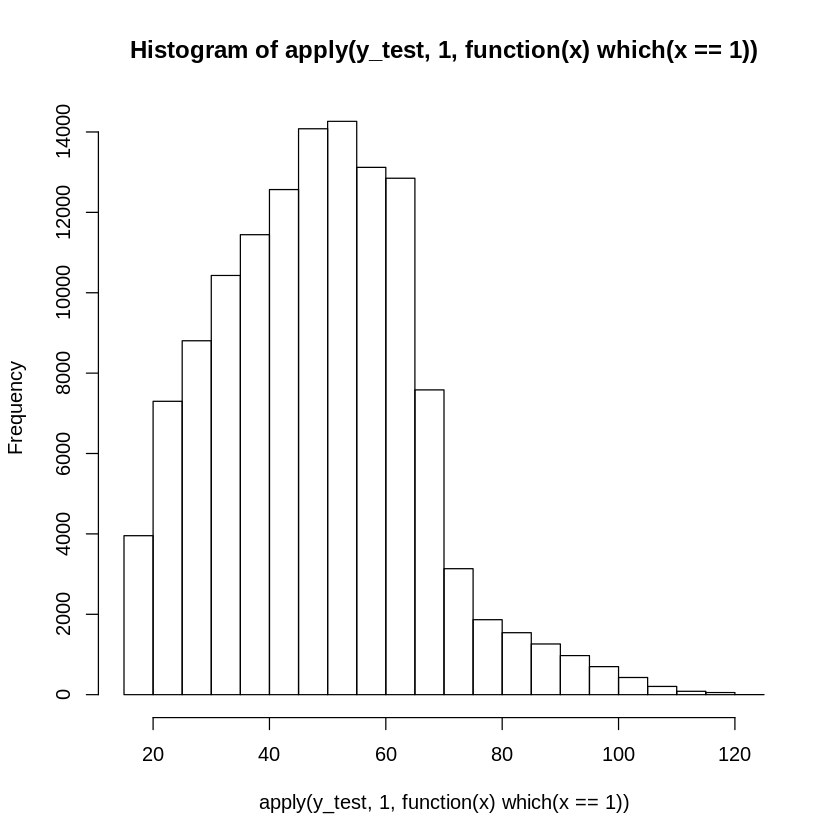

In [9]:
hist(apply(y_test,1,function(x) which(x==1)))

### NN train

In [10]:
top_8_categorical_accuracy <-
  custom_metric("rec_at_8", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 8)
  })
top_6_categorical_accuracy <-
  custom_metric("recat_6", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 6)
  })
top_4_categorical_accuracy <-
  custom_metric("rec_at_4", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 4)
  })
top_2_categorical_accuracy <-
  custom_metric("rec_at_2", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 2)
  })

In [13]:
checkpoint_dir <- "~/Downloads/checkpointsDnu/"
if (F) {
    unlink(checkpoint_dir, recursive = TRUE)
    dir.create(checkpoint_dir)
    filepath <- file.path(checkpoint_dir, "weights.{epoch:02d}-{val_loss:.2f}.hdf5")


# Create checkpoint callback
cp_callback <- callback_model_checkpoint(
  filepath = filepath,
  save_weights_only = TRUE,
  period = 5,
  verbose = 1
)
}
    

# Create a 1d convolutional NN
model <- keras_model_sequential() %>%
  layer_separable_conv_1d(
    kernel_size = 4,
    filters = 8,
    depth_multiplier = 10,
    input_shape = c(406, 3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%


layer_separable_conv_1d(
    kernel_size = 4,
    filters = 8,
    depth_multiplier = 10,
    input_shape = c(204, 3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%

  
  layer_flatten() %>%
  layer_dense(units = num_classes, activation = 'softmax')



# Configure a model for categorical classification.
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adadelta(lr = 0.01),
  metrics = c(
          "accuracy",
          top_2_categorical_accuracy,
          top_4_categorical_accuracy,
          top_6_categorical_accuracy,
          top_8_categorical_accuracy
        )
)
summary(model) # Plot summary

if (F) {
# Fit model
  history <- model %>% fit(
    x_train,
    y_train,
    epochs = 800,
    batch_size =  250,
    validation_split = 0.2,
    shuffle = T,
    verbose = 2,
    callbacks = list(cp_callback) 
  )
}

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
separable_conv1d_1 (SeparableConv1D (None, 403, 8)                  368         
________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)      (None, 201, 8)                  0           
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 201, 8)                  0           
________________________________________________________________________________
batch_normalization_1 (BatchNormali (None, 201, 8)                  32          
________________________________________________________________________________
separable_conv1d_2 (SeparableConv1D (None, 198, 8)                  968         
________________________________________________________________________________
max_pooling1d_2 (MaxPooling1

In [14]:
model %>% load_model_weights_hdf5(
  file.path("~/Downloads/checkpointsDnu/weights.800-2.73.hdf5")
)

#model <- load_model_hdf5(paste0("~/Downloads/model_dnu.h5"),
#                        custom_objects = c(rec_at_8 = top_8_categorical_accuracy, 
#                                           recat_6 = top_6_categorical_accuracy,
#                                           rec_at_4 = top_4_categorical_accuracy,
#                                           rec_at_2 = top_2_categorical_accuracy
#                                          ))
#save_model_hdf5(model, paste0("~/Downloads/model_dnu.h5"))
evaluate(model, x_test, y_test)

$loss
[1] 2.719626

$acc
[1] 0.1991156

$rec_at_2
[1] 0.3357865

$rec_at_4
[1] 0.5103206

$recat_6
[1] 0.6286797

$rec_at_8
[1] 0.7188961

In [17]:
plot(history) +
  theme_bw()

ERROR: Error in .External2(C_savehistory, file): no history available to save


### Confusion matrix

In [21]:
Y_test_hat <- predict_classes(model, x_test)
# Calculate confusion matrix
cm <- table(apply(y_test,1,which.max), Y_test_hat)
# Plot matrix
dtCM <- as.data.frame(cm)
colnames(dtCM) <- c("c1","c2","freq")
dtCM$c1 <- as.numeric(dtCM$c1)
dtCM$c2 <- as.numeric(dtCM$c2)
dtCM$freq <- as.numeric(dtCM$freq)
dim(dtCM)

[1] 11021     3

In [22]:
# insert 0 values if not exists
#for(x in seq(0,120)) {
#    for (y in seq(1,120)) {
#        if (is.null(dtCM[x, y])) {
#            dtCM <- rbind(dtCM, data.frame("c1"=x,"c2"=y,"freq"=0))
#        } 
#    }
#}
#dim(dtCM)

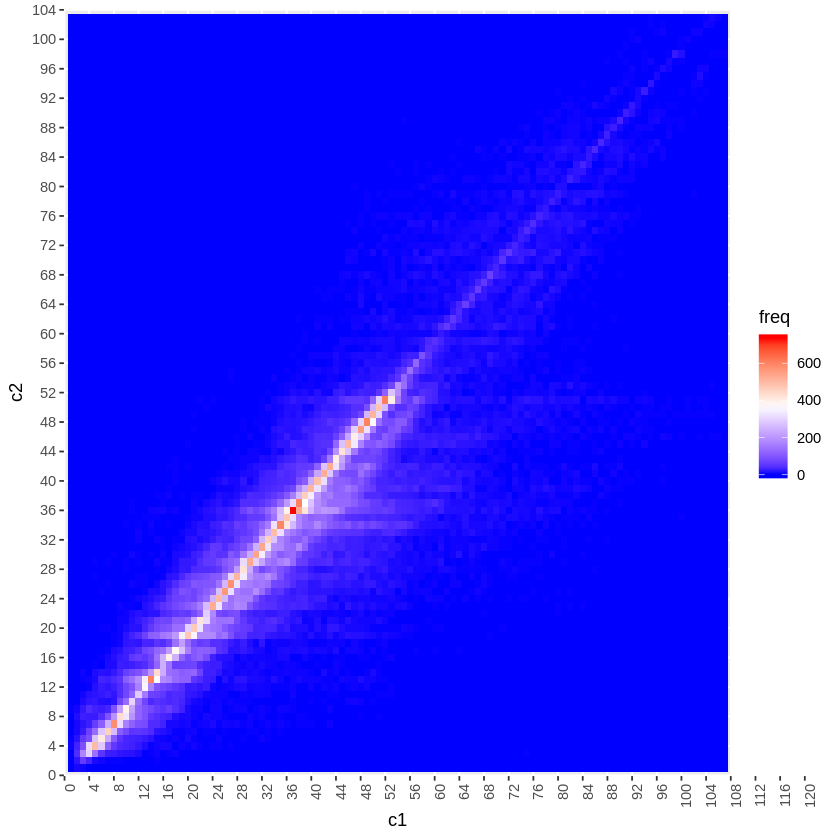

In [23]:
ggplot(data=dtCM, aes(c1, c2, fill = freq)) +
  geom_tile() +
  scale_fill_gradientn(colours=c("#0000FFFF","#FFFFFFFF","#FF0000FF"))+
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  #scale_fill_gradient(breaks=seq(from=-.5, to=4, by=.2))
  scale_x_discrete(breaks=seq(from=0,to=120,by=4), limits=seq(0,120)) +
  scale_y_discrete(breaks=seq(from=0,to=120,by=4), limits=seq(0,120)) 

### MSE error acc_at_1

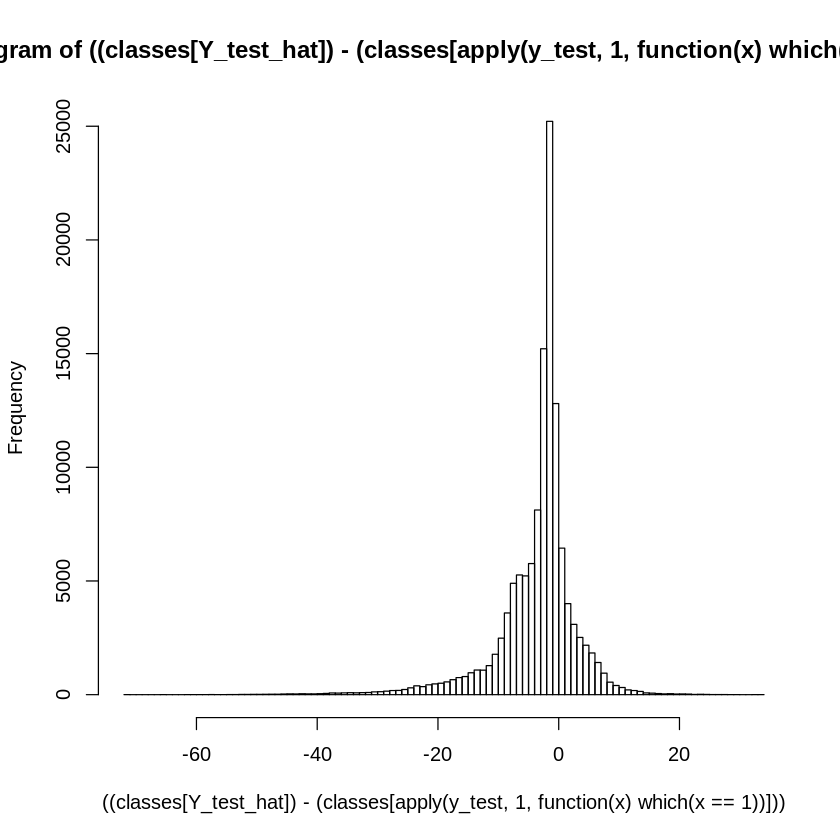

In [20]:
# Output dimension
classes <- seq(
    from = 0.1,
    to = 14 / 0.0864,
    by = output_resolution
  )


hist(((classes[Y_test_hat]) - (classes[apply(y_test,1,function(x) which(x==1))])), breaks=100)

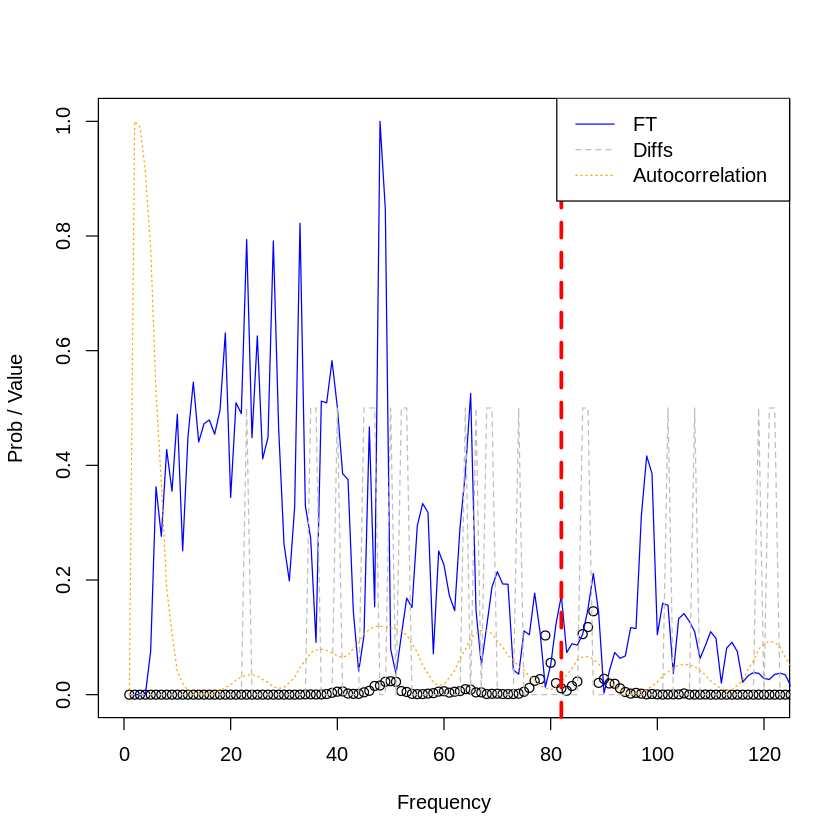

In [43]:
select_test <- 1930

y_hats <- predict(model, x_test)

plot(
  y_hats[select_test,],
  lty = 1,
  ylim = c(0, 1),
  xlim = c(0, 120),
  col = "black",
  xlab = "Frequency",
  ylab = "Prob / Value"
)


lines(x_test[select_test, , 1], lty = 1, col = "blue")
lines(x_test[select_test, , 2], lty = 2, col = "grey")
lines(x_test[select_test, , 3], lty = 3, col = "orange")


abline(
  v = which(y_test[select_test, ]==1)[1],
  col = "red",
  lwd = 3,
  lty = 2
)

abline(
  v = which(y_test[select_test, ]==1)[2],
  col = "red",
  lwd = 3,
  lty = 2
)

legend(
  "topright",
  c("FT", "Diffs", "Autocorrelation"),
  lty = c(1, 2, 3, 4),
  col = c("blue", "grey", "orange")
)